[波形データ] (5, 1000, 7)
   ↓
Encoder CNN / Transformer
   ↓
[速度マップ] (1, 70, 70)        ← この出力に対し…
   ↓
VelocityMapFn (連続関数化)
   ↓
PINN損失 (波動方程式 ∂²u/∂t² = V²(∂²u/∂x² + ∂²u/∂z²))

🧩 1. 波形 → 速度マップモデル

In [1]:
import numpy as np
import os 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [2]:
# ----------------------------
# 2) Dataset 準備
# ----------------------------
class WaveformDataset(Dataset):
    def __init__(self, waves_path, vels_path):
        self.waves = np.load(waves_path)
        self.vels  = np.load(vels_path)
    def __len__(self):
        return len(self.waves)
    def __getitem__(self, idx):
        x = torch.from_numpy(self.waves[idx]).float()
        y = torch.from_numpy(self.vels[idx]).float()
        return x, y

train_ds = WaveformDataset("../dataset_one_batch/train_waves.npy",
                          "../dataset_one_batch/train_vels.npy")
val_ds   = WaveformDataset("../dataset_one_batch/val_waves.npy",
                          "../dataset_one_batch/val_vels.npy")

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=16, shuffle=False, num_workers=2)

In [3]:
class WaveformEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv3d(1, 16, kernel_size=(3, 5, 3), padding=1)
        self.conv2 = nn.Conv3d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.AdaptiveAvgPool3d((1, 10, 10))   # 空間特徴を維持！
        self.fc = nn.Linear(32 * 10 * 10, 1024)
        self.out = nn.Linear(1024, 70 * 70)

    def forward(self, x):  # [B, 5, 1000, 7]
        x = x.unsqueeze(1)  # [B,1,5,1000,7]
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)                   # [B,32,1,10,10]
        x = x.view(x.size(0), -1)          # [B, 32*10*10]
        x = F.relu(self.fc(x))
        x = self.out(x)
        return x.view(-1, 1, 70, 70)       # [B, 1, 70, 70]

🧮 2. 速度マップ → 連続関数化（grid_sample）

In [4]:
class VelocityMapFn(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, waveform, coords):  # waveform: [B, 5, 1000, 7], coords: [B, 2]
        v_grid = self.model(waveform)  # [B, 1, 70, 70]
        coords = (coords + 1) / 2  # [-1, 1] → [0, 1]
        coords = coords.unsqueeze(1).unsqueeze(1)  # [B, 1, 1, 2]
        return F.grid_sample(v_grid, coords, align_corners=True).view(-1, 1)


📐 3. 波動場ネットワーク u(x,z,t)

In [5]:
class WaveNet(nn.Module):
    def __init__(self, in_dim=3, hidden=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.Tanh(),
            nn.Linear(hidden, hidden),
            nn.Tanh(),
            nn.Linear(hidden, 1),
        )

    def forward(self, xzt):  # [B, 3]
        return self.net(xzt)



📘 4. PDE残差（PINN損失）

In [6]:
def compute_pde_residual(u_model, v_fn, waveform, xzt):
    xzt.requires_grad_(True)
    u = u_model(xzt)  # [B, 1]

    grads = torch.autograd.grad(u, xzt, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x, u_z, u_t = grads[:, 0:1], grads[:, 1:2], grads[:, 2:3]

    u_xx = torch.autograd.grad(u_x, xzt, grad_outputs=torch.ones_like(u_x), create_graph=True)[0][:, 0:1]
    u_zz = torch.autograd.grad(u_z, xzt, grad_outputs=torch.ones_like(u_z), create_graph=True)[0][:, 1:2]
    u_tt = torch.autograd.grad(u_t, xzt, grad_outputs=torch.ones_like(u_t), create_graph=True)[0][:, 2:3]

    v = v_fn(waveform, xzt[:, :2])  # x, z座標からV(x,z)
    residual = u_tt - v**2 * (u_xx + u_zz)
    return residual


🔁 5. 学習ループ（PINN + data loss）

In [7]:
# モデルを GPU に載せる
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = WaveNet().to(device)


# オプティマイザ & スケジューラ
# optimizer = torch.optim.AdamW(wave_model.parameters(), lr=1e-3, weight_decay=1e-5)
waveform_encoder = WaveformEncoder().to(device)
velocity_map_fn = VelocityMapFn(waveform_encoder).to(device)
optimizer = torch.optim.Adam(list(waveform_encoder.parameters()) + list(model.parameters()), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=3
)
criterion = nn.L1Loss()

In [8]:
def sample_coords(batch_size, device=None, requires_grad=True):
    coords = 2 * torch.rand(batch_size, 3, device=device)
    coords = coords - 1
    if requires_grad:
        coords.requires_grad_()
    return coords

In [9]:


epochs = 200  # 任意で変更
losses_total = []
losses_data  = []
losses_pde   = []

best_loss_data = float('inf')
best_model_path = "best_pinn_model.pth"

for epoch in range(epochs):
    velocity_map_fn.train()
    waveform_encoder.train()
    running_loss      = 0.0
    running_loss_data = 0.0
    running_loss_pde  = 0.0

    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)
        batch_size = xb.shape[0]
        xzt = sample_coords(batch_size=batch_size).to(device)

        residual = compute_pde_residual(model, velocity_map_fn, xb, xzt)
        loss_pde = (residual**2).mean()

        v_pred = waveform_encoder(xb)
        loss_data = F.mse_loss(v_pred, yb)

        loss = loss_data + 0.01 * loss_pde

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss      += loss.item() * batch_size
        running_loss_data += loss_data.item() * batch_size
        running_loss_pde  += loss_pde.item() * batch_size

    epoch_loss      = running_loss / len(train_loader.dataset)
    epoch_loss_data = running_loss_data / len(train_loader.dataset)
    epoch_loss_pde  = running_loss_pde / len(train_loader.dataset)

    losses_total.append(epoch_loss)
    losses_data.append(epoch_loss_data)
    losses_pde.append(epoch_loss_pde)

    print(f"Epoch {epoch+1}/{epochs} | Loss: {epoch_loss:.6f} | Data: {epoch_loss_data:.6f} | PDE: {epoch_loss_pde:.6f}")

    # 📌 ベストモデル保存
    if epoch_loss_data < best_loss_data:
        best_loss_data = epoch_loss_data
        torch.save(waveform_encoder.state_dict(), best_model_path)
        print(f"✅ Best model saved at epoch {epoch+1} with data loss {best_loss_data:.6f}")

print("Training finished!")


/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:824: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:181.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1/200 | Loss: 7293230.580000 | Data: 6477077.637500 | PDE: 81615296.015650
✅ Best model saved at epoch 1 with data loss 6477077.637500
Epoch 2/200 | Loss: 6404105.665000 | Data: 5678182.855000 | PDE: 72592281.639531
✅ Best model saved at epoch 2 with data loss 5678182.855000
Epoch 3/200 | Loss: 3284184.175000 | Data: 2662915.357500 | PDE: 62126884.653750
✅ Best model saved at epoch 3 with data loss 2662915.357500
Epoch 4/200 | Loss: 3155307.788750 | Data: 2730152.443750 | PDE: 42515535.706250
Epoch 5/200 | Loss: 3458131.662500 | Data: 2951142.557500 | PDE: 50698913.192500
Epoch 6/200 | Loss: 2355826.243750 | Data: 2291553.290000 | PDE: 6427294.900000
✅ Best model saved at epoch 6 with data loss 2291553.290000
Epoch 7/200 | Loss: 3622143.690000 | Data: 3082209.116250 | PDE: 53993458.405000
Epoch 8/200 | Loss: 2096682.242500 | Data: 1973878.308750 | PDE: 12280393.811250
✅ Best model saved at epoch 8 with data loss 1973878.308750
Epoch 9/200 | Loss: 1852916.612500 | Data: 1489157.62

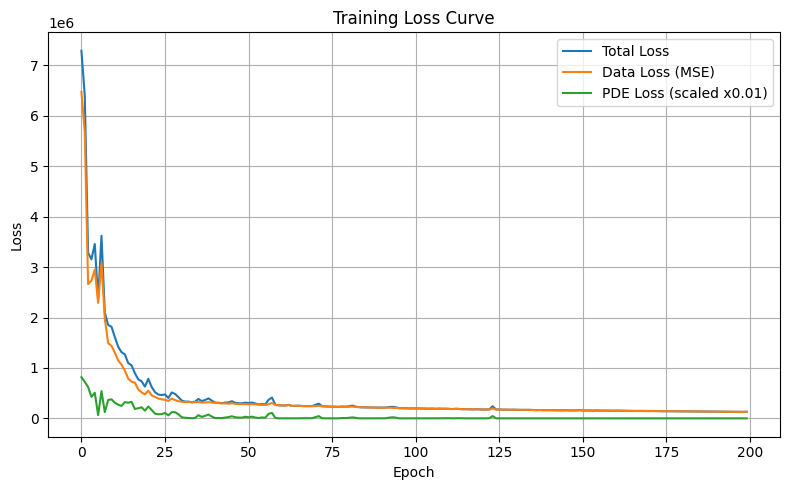

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(losses_total, label='Total Loss')
plt.plot(losses_data,  label='Data Loss (MSE)')
plt.plot([0.01 * x for x in losses_pde], label='PDE Loss (scaled x0.01)')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


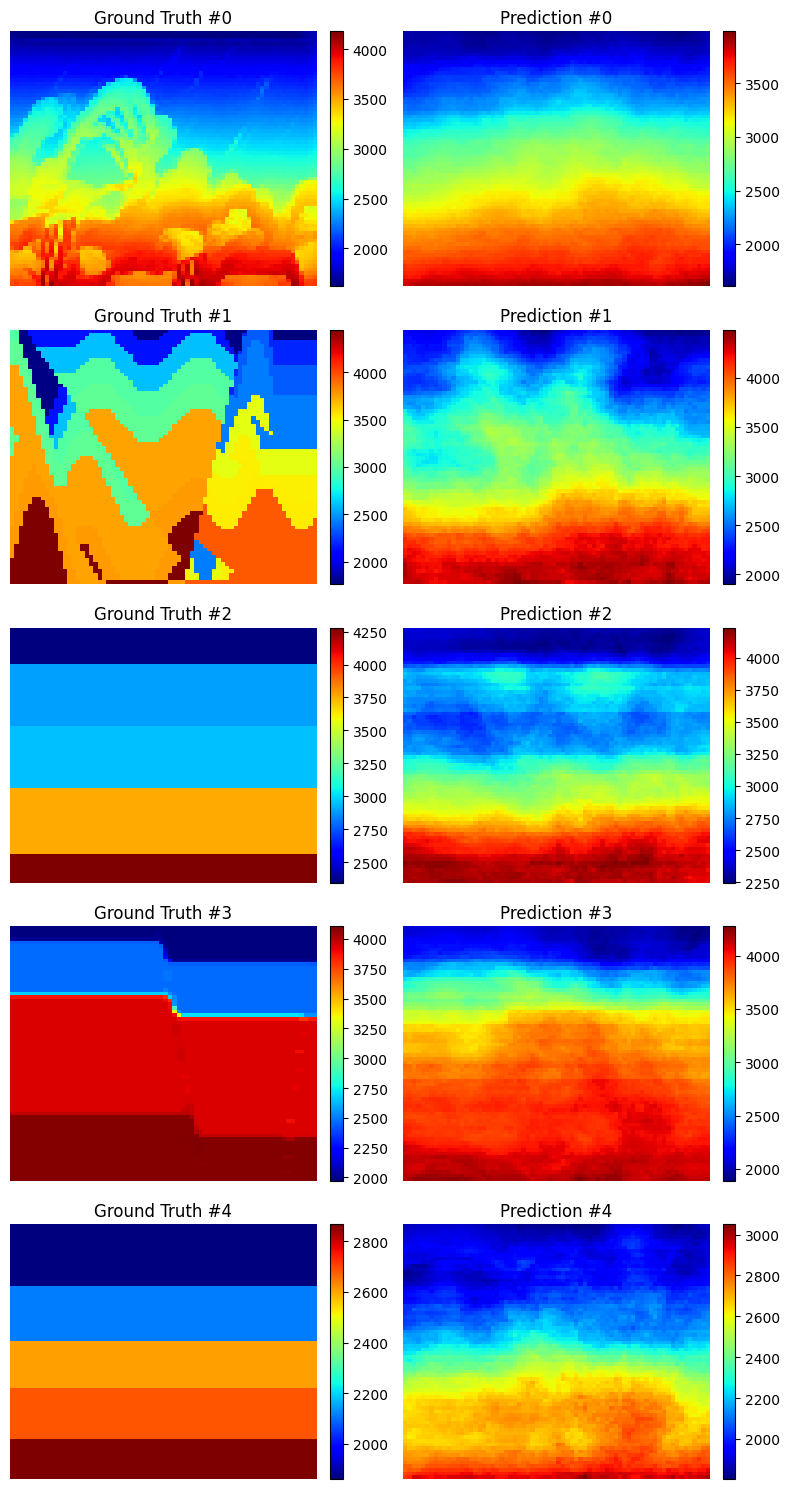

In [11]:
import matplotlib.pyplot as plt

# 予測用: モデルを推論モードに
waveform_encoder.eval()

n_show = 5  # 表示したいサンプル数

with torch.no_grad():
    xb, yb = next(iter(val_loader))
    xb = xb.to(device)
    yb = yb.to(device)
    v_pred = waveform_encoder(xb)  # [B,1,70,70]

# 描画
fig, axes = plt.subplots(n_show, 2, figsize=(8, n_show*3))

for i in range(n_show):
    # 0番目からn_show番目まで
    pred_img = v_pred[i, 0].detach().cpu().numpy()  # [70,70]
    gt_img   = yb[i, 0].detach().cpu().numpy()      # [70,70]

    # 正解
    ax_gt = axes[i, 0]
    im_gt = ax_gt.imshow(gt_img, cmap="jet", aspect='auto')
    ax_gt.set_title(f"Ground Truth #{i}")
    fig.colorbar(im_gt, ax=ax_gt, fraction=0.046, pad=0.04)
    ax_gt.axis("off")

    # 予測
    ax_pred = axes[i, 1]
    im_pred = ax_pred.imshow(pred_img, cmap="jet", aspect='auto')
    ax_pred.set_title(f"Prediction #{i}")
    fig.colorbar(im_pred, ax=ax_pred, fraction=0.046, pad=0.04)
    ax_pred.axis("off")

plt.tight_layout()
plt.show()
